In [0]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install numpy 
!pip3 install matplotlib
!pip3 install pandas

     |████████████████████████████████| 592.3MB 16.6MB/s 
ERROR: torchvision 0.3.0 has requirement torch>=1.1.0, but you'll have torch 0.3.0.post4 which is incompatible.
ERROR: fastai 1.0.54 has requirement torch>=1.0.0, but you'll have torch 0.3.0.post4 which is incompatible.
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
     |████████████████████████████████| 676.9MB 23kB/s 
  Found existing installation: torch 0.3.0.post4
    Uninstalling torch-0.3.0.post4:
      Successfully uninstalled torch-0.3.0.post4


In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

gc = 1 # Set to 1 if using Google Colab, 0 if using Jupyter Notebook.
if gc == 1:
  from google.colab import files
  files.upload()

print("GPU Available: ", torch.cuda.is_available())

Saving training_set.csv to training_set.csv
Saving training_set_metadata.csv to training_set_metadata.csv
True


In [0]:
# Show available files
! ls

sample_data  training_set.csv  training_set_metadata.csv


In [0]:
# Load in data

train_data = pd.read_csv('training_set.csv')
train_metadata = pd.read_csv('training_set_metadata.csv')

train_data.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


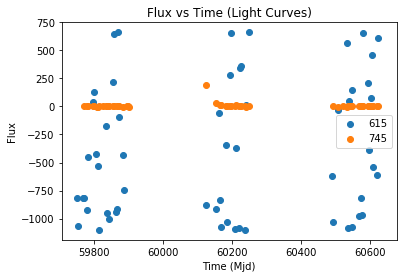

In [0]:
# Data Visualization for 2 sample data points

sample_data_1 = train_data[train_data.object_id == 615][train_data.passband == 1]
sample_data_2 = train_data[train_data.object_id == 745][train_data.passband == 1]
plt.scatter(sample_data_1['mjd'], sample_data_1['flux'], label = '615')
plt.scatter(sample_data_2['mjd'], sample_data_2['flux'], label = '745')

plt.title('Flux vs Time (Light Curves)')
plt.xlabel('Time (Mjd)')
plt.ylabel('Flux')
plt.legend()

In [0]:
# Feature Engineering/Data Processing
train_data['flux_fract_unc'] = train_data['flux']/train_data['flux_err']
train_data['flux_by_flux_ratio_sq'] = train_data['flux']*np.power(train_data['flux_fract_unc'], 2)

# Aggregate Data
aggs = {
    'mjd' : ['min', 'max', 'size'],
    'flux' : ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'flux_err' : ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'detected' : ['mean'],
    'flux_fract_unc' : ['sum', 'skew'],
    'flux_by_flux_ratio_sq' : ['sum', 'skew']
}

agg_data = train_data.groupby(['object_id']).agg(aggs)
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
              ]

agg_data.columns = new_columns
agg_data['mjd_diff'] = agg_data['mjd_max'] - agg_data['mjd_min']
agg_data['flux_diff'] = agg_data['flux_max'] - agg_data['flux_min']
agg_data['flux_diff_mean'] = agg_data['flux_diff']/agg_data['flux_mean']
agg_data['flux_by_time'] = agg_data['flux_diff']/agg_data['mjd_diff']

agg_data.head()



,mjd_min,mjd_max,mjd_size,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_fract_unc_sum,flux_fract_unc_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,mjd_diff,flux_diff,flux_diff_mean,flux_by_time
object_id,,,,,,,,,,,,,,,,,,,,,,,,
615,59750.4229,60624.2132,352,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835269,1.744747,1.623740,0.946023,-9060.302923,0.074759,-9.601766e+08,-1.414322,873.7903,1761.066406,-14.306331,2.015434
713,59825.2600,60674.0798,350,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,1.509888,1.633246,0.171429,-294.371461,-0.527471,-2.875087e+04,-3.454554,848.8198,29.506064,-20.730002,0.034761
730,59798.3205,60652.1660,330,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,1.721134,1.823726,0.069697,335.303259,3.553707,1.046502e+05,5.989138,853.8455,66.469870,29.315018,0.077848
745,59770.3662,60624.0722,351,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,1.819875,3.537324,10.741655,0.173789,1645.743729,5.941321,1.439125e+07,11.141069,853.7060,236.289675,26.521968,0.276781
1124,59750.4229,60624.2132,352,-16.543753,143.600189,7.145702,1.141288,20.051722,4.406298,0.695277,11.383690,2.753004,2.214854,1.933837,1.794938,0.173295,1189.568855,4.736771,3.015599e+06,7.908174,873.7903,160.143942,22.411225,0.183275


In [0]:
# Reset Index

agg_data = agg_data.reset_index()
agg_data.head()

,object_id,mjd_min,mjd_max,mjd_size,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_fract_unc_sum,flux_fract_unc_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,mjd_diff,flux_diff,flux_diff_mean,flux_by_time
0,615,59750.4229,60624.2132,352,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835269,1.744747,1.623740,0.946023,-9060.302923,0.074759,-9.601766e+08,-1.414322,873.7903,1761.066406,-14.306331,2.015434
1,713,59825.2600,60674.0798,350,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,1.509888,1.633246,0.171429,-294.371461,-0.527471,-2.875087e+04,-3.454554,848.8198,29.506064,-20.730002,0.034761
2,730,59798.3205,60652.1660,330,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,1.721134,1.823726,0.069697,335.303259,3.553707,1.046502e+05,5.989138,853.8455,66.469870,29.315018,0.077848
3,745,59770.3662,60624.0722,351,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,1.819875,3.537324,10.741655,0.173789,1645.743729,5.941321,1.439125e+07,11.141069,853.7060,236.289675,26.521968,0.276781
4,1124,59750.4229,60624.2132,352,-16.543753,143.600189,7.145702,1.141288,20.051722,4.406298,0.695277,11.383690,2.753004,2.214854,1.933837,1.794938,0.173295,1189.568855,4.736771,3.015599e+06,7.908174,873.7903,160.143942,22.411225,0.183275


In [0]:
# Merge aggregated data with metadata

all_data = agg_data.merge(
                        right=train_metadata,
                        how='outer',
                        on='object_id')
all_data.head()

,object_id,mjd_min,mjd_max,mjd_size,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_fract_unc_sum,flux_fract_unc_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,mjd_diff,flux_diff,flux_diff_mean,flux_by_time,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,59750.4229,60624.2132,352,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835269,1.744747,1.623740,0.946023,-9060.302923,0.074759,-9.601766e+08,-1.414322,873.7903,1761.066406,-14.306331,2.015434,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,59825.2600,60674.0798,350,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,1.509888,1.633246,0.171429,-294.371461,-0.527471,-2.875087e+04,-3.454554,848.8198,29.506064,-20.730002,0.034761,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,59798.3205,60652.1660,330,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,1.721134,1.823726,0.069697,335.303259,3.553707,1.046502e+05,5.989138,853.8455,66.469870,29.315018,0.077848,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,59770.3662,60624.0722,351,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,1.819875,3.537324,10.741655,0.173789,1645.743729,5.941321,1.439125e+07,11.141069,853.7060,236.289675,26.521968,0.276781,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,59750.4229,60624.2132,352,-16.543753,143.600189,7.145702,1.141288,20.051722,4.406298,0.695277,11.383690,2.753004,2.214854,1.933837,1.794938,0.173295,1189.568855,4.736771,3.015599e+06,7.908174,873.7903,160.143942,22.411225,0.183275,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [0]:
# Convert targets to be compatible with model.

y = all_data['target']
classes = sorted(y.unique())

print('Unique Classes: ', classes)

class_map = dict()
for i, val in enumerate(classes):
   class_map[val] = i
    
# [6, 15, 16, 42] -> [0, 1, 2, 3] 
def to_categorical(y, num_classes):
  """1-hot encode"""
  return np.eye(num_classes, dtype='uint8')[y]

y_map = np.array([class_map[val] for val in y])
y_categorical = to_categorical(y_map, 14)

print("Target Shape:", y_categorical.shape)
print("Categorized examples: ", y_categorical[0:5])

Unique Classes:  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
(7848, 14)


In [0]:
#Final Touches

#Remove Unnecessary Data
del all_data['object_id'], all_data['distmod'], all_data['ra'], all_data['decl'], all_data['gal_l'], all_data['gal_b']

#Remove Invalid/Empty Data
train_mean = all_data.mean(axis=0) 
all_data.fillna(train_mean, inplace=True)

#Format Data for Learning
from sklearn.preprocessing import StandardScaler 
ss = StandardScaler()
myData = ss.fit_transform(all_data)

print('Data shape: ', myData.shape)

Data shape:  (7848, 30)


In [0]:
import torch.nn as nn

class NeuralNetwork(nn.Module):
  def __init__(self, size_inputs, size_outputs):
    super(NeuralNetwork, self).__init__()
    self.net = nn.Sequential(
      nn.Linear(size_inputs, 24), #30 input vars -> 24 unique features
      nn.BatchNorm1d(24),
      nn.LeakyReLU(),
      nn.Linear(24, 16), #24 features -> 16 features
      nn.BatchNorm1d(16),
      nn.LeakyReLU(),
      nn.Linear(16, size_outputs), #16 features -> 14 possible outputs
      nn.Sigmoid()
    )
  
  def forward(self, inputs):
    results = self.net(inputs)
    return results
  

In [0]:
from sklearn.model_selection import train_test_split

size_inputs = myData.shape[1]
size_outputs = y_categorical.shape[1]

# Initialize Model's Neural Network, Loss Function, and Optimizer
myNN = NeuralNetwork(size_inputs, size_outputs)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(myNN.parameters(), lr=0.001)

# Split data into testing and training sets.
xTrain, xTest, yTrain, yTest = train_test_split(myData, y_categorical, test_size=0.2)

# Create Tensor Objects
train_x = torch.FloatTensor(xTrain)
train_y = torch.FloatTensor(yTrain)
test_x = torch.FloatTensor(xTest)
test_y = torch.FloatTensor(yTest)

# Make sure model is working. 
results = myNN(train_x)
error = criterion(results, train_y)
print("Results: ", results[0:5])
print("Error:", error)


Results:  tensor([[0.4319, 0.5652, 0.5003, 0.4641, 0.4341, 0.5177, 0.4419, 0.4616, 0.5082,
         0.5476, 0.5723, 0.4900, 0.4712, 0.4863],
        [0.4586, 0.5217, 0.5067, 0.4879, 0.4579, 0.4950, 0.4696, 0.4458, 0.4614,
         0.5473, 0.6018, 0.5193, 0.4692, 0.5043],
        [0.4357, 0.4997, 0.5565, 0.4173, 0.3953, 0.4851, 0.5516, 0.5147, 0.4687,
         0.4344, 0.4681, 0.5920, 0.4042, 0.4108],
        [0.5748, 0.4412, 0.3837, 0.4361, 0.6135, 0.3544, 0.2776, 0.5808, 0.6500,
         0.5823, 0.5225, 0.7310, 0.5141, 0.4372],
        [0.5276, 0.4927, 0.5182, 0.4105, 0.5831, 0.4233, 0.3922, 0.5564, 0.5692,
         0.5029, 0.3942, 0.7266, 0.4060, 0.3687]], grad_fn=<SliceBackward>)
Error: tensor(0.6833, grad_fn=<BinaryCrossEntropyBackward>)


Epoch:  0 , Training Loss: 0.6687524914741516 Test Loss: 0.6639430522918701
Epoch:  1 , Training Loss: 0.6662685871124268 Test Loss: 0.6618569493293762
Epoch:  2 , Training Loss: 0.6638174057006836 Test Loss: 0.6597669720649719
Epoch:  3 , Training Loss: 0.6614425778388977 Test Loss: 0.657658576965332
Epoch:  4 , Training Loss: 0.6591002345085144 Test Loss: 0.6555445194244385
Epoch:  5 , Training Loss: 0.6567552089691162 Test Loss: 0.6534290909767151
Epoch:  6 , Training Loss: 0.6544646620750427 Test Loss: 0.6512951254844666
Epoch:  7 , Training Loss: 0.6522075533866882 Test Loss: 0.6491531729698181
Epoch:  8 , Training Loss: 0.6499757766723633 Test Loss: 0.6470009088516235
Epoch:  9 , Training Loss: 0.6477611064910889 Test Loss: 0.644837498664856
Epoch:  10 , Training Loss: 0.6455534100532532 Test Loss: 0.6426657438278198
Epoch:  11 , Training Loss: 0.6433584094047546 Test Loss: 0.6404892802238464
Epoch:  12 , Training Loss: 0.6411622762680054 Test Loss: 0.6383068561553955
Epoch:  13 

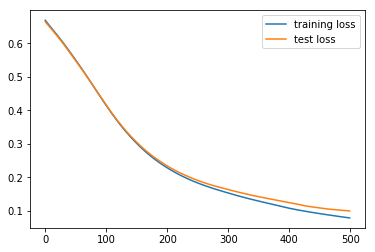

In [0]:
# Function to train or test model
def train_test(network, inp, labels, optimizer=None, criterion=None, mode='train'):
  preds = network(inp)
  error = criterion(preds, labels)
  
  if mode == 'train':
    optimizer.zero_grad()
    error.backward()
    optimizer.step()
  
  return preds, error.item()

# Training Length
num_epochs = 500 

# Store losses
train_losses = []
test_losses = []

# Train and test at every epoch
for i in range(num_epochs):
  _, train_loss = train_test(myNN, train_x, train_y, optimizer, criterion, mode='train')
  train_losses.append(train_loss)
  
  _, test_loss = train_test(myNN, test_x, test_y, criterion=criterion, mode='test')
  test_losses.append(test_loss)
  print("Epoch: ", i, ", Training Loss:", train_loss, "Test Loss:", test_loss)

  
# Simple plot for losses
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test loss')

plt.legend()
plt.show()

CPU training 100 epochs takes 2.2213473320007324 seconds.


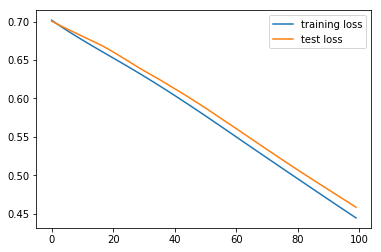

GPU training 100 epochs takes 0.46485280990600586 seconds.


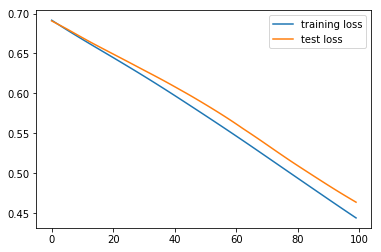

In [0]:
# GPU vs CPU comparison

import time

num_epochs = 100

#CPU
myNN = NeuralNetwork(size_inputs, size_outputs)
optimizer = torch.optim.Adam(myNN.parameters(), lr=0.001)

train_losses = []
test_losses = []

start_time = time.time()
for i in range(num_epochs):
  _, train_loss = train_test(myNN, train_x, train_y, optimizer, criterion, mode='train')
  train_losses.append(train_loss)
  
  _, test_loss = train_test(myNN, test_x, test_y, criterion=criterion, mode='test')
  test_losses.append(test_loss)

end_time = time.time() - start_time
print("CPU training 100 epochs takes", end_time,"seconds.")
  
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test loss')

plt.legend()
plt.show()

#GPU
myNN = NeuralNetwork(size_inputs, size_outputs)
optimizer = torch.optim.Adam(myNN.parameters(), lr=0.001)

if torch.cuda.is_available():
  myNN = myNN.cuda()
  train_x, train_y = train_x.cuda(), train_y.cuda()
  test_x, test_y = test_x.cuda(), test_y.cuda()
  

train_losses = []
test_losses = []

start_time = time.time()
for i in range(num_epochs):
  _, train_loss = train_test(myNN, train_x, train_y, optimizer, criterion, mode='train')
  train_losses.append(train_loss)
  
  _, test_loss = train_test(myNN, test_x, test_y, criterion=criterion, mode='test')
  test_losses.append(test_loss)

end_time = time.time() - start_time
print("GPU training 100 epochs takes", end_time,"seconds.")
  
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test loss')

plt.legend()
plt.show()

In [0]:
# Support Vector Machine attempt to compare to Neural Network
# Note: Best practices typical for Machine Learning were not 
# applied to this demo. While SVM may look weaker, I expect 
# that stronger data analysis will improve it greatly.

from sklearn import svm

xTrain, xTest, yTrain, yTest = train_test_split(myData, y_map, test_size=0.2)
#[6, 14, 15, ... 92, 95] -> [0, 1, 2, ..., 12, 13]

criterion = nn.BCELoss()
yTest = to_categorical(yTest, 14)

clf = svm.SVC(max_iter=20000)
clf.fit(xTrain, yTrain)
preds = clf.predict(xTest)
preds = to_categorical(preds, 14)

print(criterion(torch.FloatTensor(preds), torch.FloatTensor(yTest)))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


tensor(0.3646)
